### Common Test I. Multi-Class Classification (Method 2 - ResNet50 Transfer Learning)

#### **Name:** Yashwardhan Deshmukh [yaashwardhan@gmail.com](mailto:yaashwardhan@gmail.com)

---

**Task:** Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.

**Dataset:** https://drive.google.com/file/d/1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A/view

**Dataset Description:** The Dataset consists of three classes, strong lensing images with no substructure, subhalo substructure, and vortex substructure. The images have been normalized using min-max normalization, but you are free to use any normalization or data augmentation methods to improve your results.

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve) 

--- 

*Trained model for this task can be found in the respective folder in [HERE](https://drive.google.com/drive/folders/1x5gm4ywOQ8brxMn11KjLBxsehQuxtx19?usp=sharing)*

**Strategy**: Now that we have a base and have noticed that CNN with channel wise attentions and residuals do perform well, we can use the best pretrained network that uses residual connections for transfer learning, a.k.a ResNet-50. This implemtation is extremely easy since there is already a library that implements the models architecture.

Here are the steps in detail: 
*   Firstly, we use the pretrained ResNet50 architecture and remove its classification head and then flatten it.
*   Then we implement batch normalization and dropout to improve model generalization at the expense of early convergence.
*   Finally we apply our dense layer with 3 outputs and a softmax activation to generate probabilities for the 3 classes.


**Results:** Average AUC on validation set is 0.98

<img src="results/ResNet50_results.png" alt="(Image Load Error: Unable to load image, make sure you have downloaded the results folder)" width="700"/>


In [2]:
import pandas as pd
import numpy as np
import os
from keras.utils import to_categorical
from keras.utils import Sequence
import random
from keras import optimizers, metrics
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from keras import layers, models, applications
from keras.models import load_model
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [42]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [ ]:
"""
UNCOMMENT AND RUN ONE TIME to convert .npy images to jpg. 
But ofcourse, if we want to use .npy images, we can repeat it using either 'tf.tile(image, [1, 1, 3])' or 'np.broadcast_to(img, (x, x, 3)) such that the images now have three channels and they can be easily used with ResNet50'
"""
# import os
# import numpy as np
# from PIL import Image

# def convert_npy_to_jpeg(input_dir, output_dir):
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     classes = ['no', 'sphere', 'vort']

#     for c in classes:
#         class_dir = os.path.join(input_dir, c)
#         output_class_dir = os.path.join(output_dir, c)
#         if not os.path.exists(output_class_dir):
#             os.makedirs(output_class_dir)

#         for file in os.listdir(class_dir):
#             if file.endswith('.npy'):
#                 npy_file = os.path.join(class_dir, file)
#                 img = np.load(npy_file)
#                 img = img.squeeze()  # remove the first dimension
#                 img = np.uint8(img * 255)  # convert to 8-bit integer
#                 img = Image.fromarray(img)
#                 img.save(os.path.join(output_class_dir, os.path.splitext(file)[0] + '.jpeg'))

# convert_npy_to_jpeg('dataset/train', 'converted_train')
# convert_npy_to_jpeg('dataset/val', 'converted_val')

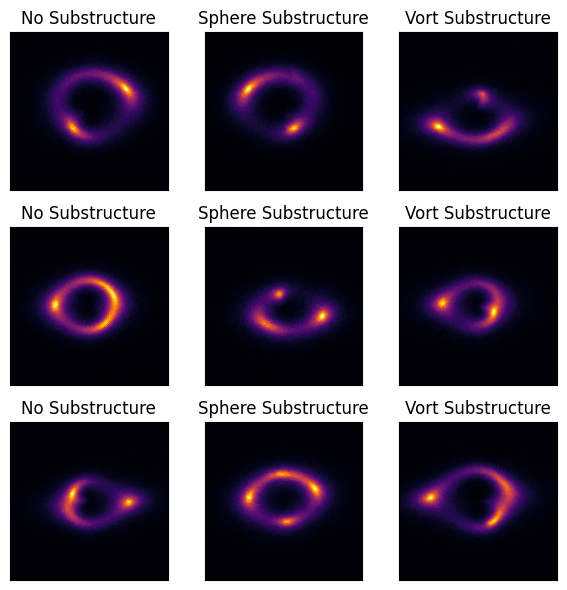

In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))

for i, (folder_path, title) in enumerate([('converted_train/no/', 'No Substructure'), ('converted_train/sphere/', 'Sphere Substructure'), ('converted_train/vort/', 'Vort Substructure')]):
    for j in range(3):
        file_name = os.listdir(folder_path)[j]
        img_path = os.path.join(folder_path, file_name)
        img = Image.open(img_path)
        img_array = np.array(img)
        axs[j, i].imshow(img_array, cmap='inferno')
        axs[j, i].set_title(title)
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
plt.tight_layout()
plt.show()

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

train_dir = "converted_train/"
val_dir = "converted_val/"

train_transform = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_transform = ImageDataGenerator(rescale=1./255)

train_generator = train_transform.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=256,
    class_mode='categorical'
)

val_generator = val_transform.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=256,
    class_mode='categorical'
)

Found 30000 images belonging to 3 classes.
Found 7500 images belonging to 3 classes.


In [112]:
weights_path = 'imagenet'

model_softmax = models.Sequential([
      applications.ResNet50(
          weights=weights_path, 
          include_top=False, 
          input_shape=(150, 150, 3)
      ),
      layers.Flatten(),
    
      layers.BatchNormalization(), # Droupout and BatchNormalization improves generalization at the expense of early convergence
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.2),
    
      layers.BatchNormalization(),
      layers.Dense(64, activation='relu'),
      layers.Dropout(0.2),
    
      layers.BatchNormalization(),
      layers.Dense(3, activation='softmax') # Softmax lets us easily calculate ROC AUC later
])

model_softmax.compile(optimizer=optimizers.Adam(learning_rate= 1e-4), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=[metrics.AUC(name='auc')])

reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.7, patience=4, min_lr=1e-5, verbose=True)
history = model_softmax.fit(train_generator, steps_per_epoch=len(train_generator),
                    epochs=50, validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[reduce_lr])

Epoch 1/50
118/118 [==============================] - 317s 2s/step - loss: 1.3603 - auc: 0.5065 - val_loss: 1.1727 - val_auc: 0.5017 - lr: 1.0000e-04
Epoch 2/50
118/118 [==============================] - 278s 2s/step - loss: 1.2205 - auc: 0.5179 - val_loss: 1.1064 - val_auc: 0.4981 - lr: 1.0000e-04
Epoch 3/50
118/118 [==============================] - 278s 2s/step - loss: 1.1724 - auc: 0.5669 - val_loss: 1.1233 - val_auc: 0.4981 - lr: 1.0000e-04
Epoch 4/50
118/118 [==============================] - 279s 2s/step - loss: 1.0975 - auc: 0.6376 - val_loss: 1.1589 - val_auc: 0.4992 - lr: 1.0000e-04
Epoch 5/50
118/118 [==============================] - 277s 2s/step - loss: 0.9732 - auc: 0.7278 - val_loss: 1.3011 - val_auc: 0.4980 - lr: 1.0000e-04
Epoch 6/50
118/118 [==============================] - ETA: 0s - loss: 0.8294 - auc: 0.8088
Epoch 6: ReduceLROnPlateau reducing learning rate to 6.999999823165126e-05.
118/118 [==============================] - 278s 2s/step - loss: 0.8294 - auc: 0.808

In [113]:
# model_softmax.save('model_softmax_resnet50_inference.h5')
# np.save('model_softmax_resnet50_inference.npy',history.history)

In [5]:
model_softmax = load_model('models/model_softmax_resnet50_inference.h5', compile=False)
history_load=np.load('models/model_softmax_resnet50_inference.npy',allow_pickle='TRUE').item()

In [38]:
y_true = []
y_pred = []

for i in range(len(val_generator)):
    X_batch, y_batch = val_generator[i]
    y_true.extend(y_batch)
    y_pred.extend(model_softmax.predict(X_batch))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


3/3 [==============================] - 1s 45ms/step


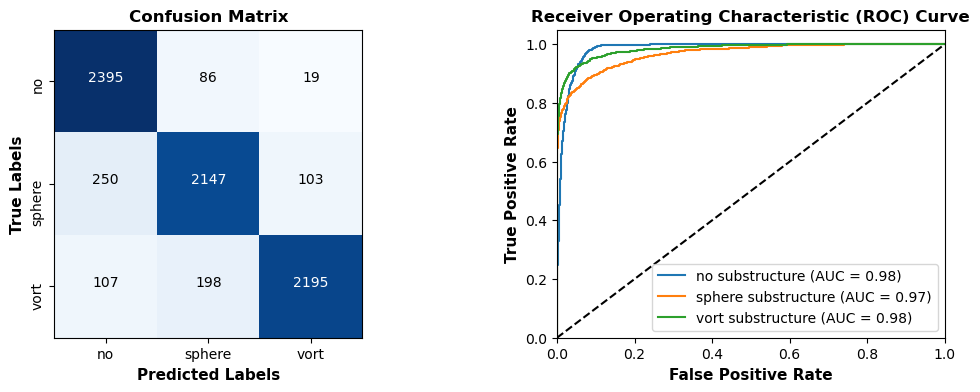

In [53]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 4)) 
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.subplot(121)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=11, fontweight='bold')
plt.ylabel('True Labels', fontsize=11, fontweight='bold')

tick_marks = np.arange(len(val_generator.class_indices))
plt.xticks(tick_marks, val_generator.class_indices)
plt.yticks(tick_marks, val_generator.class_indices, rotation=90)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.subplot(122)
for class_name, i in val_generator.class_indices.items():
    plt.plot(fpr[i], tpr[i], label=f"{class_name} substructure (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=12, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=11, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=11, fontweight='bold')
plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0.4)
plt.show()
